In [1]:
from data import MultiMolGraphDataset
from torch_geometric.loader import DataLoader
import torch
import torchmetrics
from torchmetrics import MeanAbsoluteError
from schedulers import CosineRestartsDecay

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
sdf_path = '/home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data'
target_data = '/home/calvin/code/chemprop_phd_customised/habnet/data/processed/target_data/target_data.csv'

In [3]:
# Read in target_data with pandas and then select 'psi_1_dihedral' column and convert the dihedral angles to sin and cos 
import pandas as pd
import numpy as np
# 1 & 2. Load your data
target_df = pd.read_csv(target_data)

# Drop -10 rows in the dihedral angle column
target_df = target_df[target_df['psi_1_dihedral'] != -10]

# 3. Extract the dihedral angles
angles = target_df['psi_1_dihedral']

# 3.1 Remove any -10 rows in the dihedral angle column
angles = angles[angles != -10]
# 3.2 Remove any NaN values
angles = angles.dropna()

# 4. If angles are in degrees, convert to radians
angles_rad = np.deg2rad(angles)

# 5. Compute sin & cos and assign
target_df['psi_1_dihedral_sin'] = np.sin(angles_rad)
target_df['psi_1_dihedral_cos'] = np.cos(angles_rad)

# Optional: inspect
print(target_df[['psi_1_dihedral', 'psi_1_dihedral_sin', 'psi_1_dihedral_cos']].head())



# 6. Save the modified DataFrame back to CSV
target_data = '/home/calvin/code/chemprop_phd_customised/habnet/data/processed/target_data/target_data_sin_cos.csv'
target_df.to_csv(target_data, index=False)

   psi_1_dihedral  psi_1_dihedral_sin  psi_1_dihedral_cos
0      313.550300           -0.724770            0.688991
2      292.580884           -0.923338            0.383987
3      233.012473           -0.798766           -0.601641
4       34.468778            0.565957            0.824435
5      202.755671           -0.386802           -0.922163


In [4]:
mol_dataset = MultiMolGraphDataset(
    root='.',
    sdf_folder=sdf_path,
    input_type=['r1h', 'r2h'],
    target_csv=target_data,
    target_columns=['psi_1_dihedral_sin', 'psi_1_dihedral_cos'],
    keep_hs=True,
    sanitize=False,
    force_reload=True
)

Processing...
/home/calvin/code/GINE/data.py:188: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  x = torch.tensor(atom_feats, dtype=torch.float)


No target for 'rmg_rxn_1129' in /home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data/rmg_rxn_1129.sdf
No target for 'rmg_rxn_1137' in /home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data/rmg_rxn_1137.sdf
No target for 'rmg_rxn_1141' in /home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data/rmg_rxn_1141.sdf
No target for 'rmg_rxn_1142' in /home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data/rmg_rxn_1142.sdf
No target for 'rmg_rxn_1146' in /home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data/rmg_rxn_1146.sdf
No target for 'rmg_rxn_1147' in /home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data/rmg_rxn_1147.sdf
No target for 'rmg_rxn_1152' in /home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data/rmg_rxn_1152.sdf
No target for 'rmg_rxn_1153' in /home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data/rmg_rxn_1153.sdf
No target for 'rmg_rxn_1

Done!


In [5]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool

class PairwiseMLP(nn.Module):
    def __init__(self, node_dim, hidden=256, fusion='cat'):
        super().__init__()
        self.fusion = fusion
        input_dim = {
            'cat': 2 * node_dim,
            'diff': 3 * node_dim,
            'diff2': 4 * node_dim,
            'symm': 4 * node_dim,
        }[fusion]

        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 2)  # output = [sin, cos]
        )

    def _fuse(self, h1, h2):
        if self.fusion == 'cat':
            return torch.cat([h1, h2], dim=-1)
        elif self.fusion == 'symm':
            return torch.cat([h1, h2, (h1 - h2).abs(), h1 * h2], dim=-1)
        elif self.fusion == 'diff':
            return torch.cat([h1 - h2, (h1 - h2).abs(), h1 * h2], dim=-1)
        elif self.fusion == 'diff2':
            return torch.cat([h1 - h2, (h1 - h2).abs(), h1 * h2, h1 + h2], dim=-1)

    def forward(self, pair):
        # These are the actual fields in your PairDataBatch
        h_s = global_mean_pool(pair.x_s, pair.x_s_batch)  # [B, D]
        h_t = global_mean_pool(pair.x_t, pair.x_t_batch)  # [B, D]
        
        z = self._fuse(h_s, h_t)  # [B, fused_dim]
        return self.mlp(z)

In [6]:
# Train the model
# Split the dataset into train and test sets and val sets [0.8, 0.1, 0.1]
train_size = int(0.8 * len(mol_dataset))
test_size = int(0.1 * len(mol_dataset))
val_size = len(mol_dataset) - train_size - test_size

import torch
train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(
    mol_dataset,
    [train_size, test_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(
    train_dataset,
    batch_size = 16,
    shuffle    = True,
    follow_batch = ['x_s', 'x_t']    # tells PyG to create x_s_batch, x_t_batch
)
test_loader = DataLoader(
    test_dataset,
    batch_size = 32,
    shuffle    = False,
    follow_batch = ['x_s', 'x_t']    # tells PyG to create x_s_batch, x_t_batch
)
val_loader = DataLoader(
    val_dataset,
    batch_size = 32,
    shuffle    = False,
    follow_batch = ['x_s', 'x_t']    # tells PyG to create x_s_batch, x_t_batch
)

In [7]:
# after you have made train_loader / val_loader
from collections import Counter
all_train_ids = []
all_val_ids   = []

for pair in train_loader.dataset:          # ← adjust .dataset attr if needed
    all_train_ids.append(pair.id)          # whatever unique key you use
for pair in val_loader.dataset:
    all_val_ids.append(pair.id)

leak = set(all_train_ids) & set(all_val_ids)
print(f"duplicated IDs between train/val: {len(leak)}")
assert len(leak) == 0, "⚠️ data leakage!"

duplicated IDs between train/val: 0


In [8]:
model = PairwiseMLP(
    node_dim = 133,
    hidden   = 256,
    fusion   = 'symm'
)
print(model)

PairwiseMLP(
  (mlp): Sequential(
    (0): Linear(in_features=532, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=2, bias=True)
  )
)


In [9]:
from torchmetrics import MeanAbsoluteError
from loss_utils import CircularMSELoss, cosine_angle_loss, weighted_cosine_loss, von_mises_nll_per_sample, radial_penalty, von_mises_nll


#loss_fn = MeanAbsoluteError().to(device='cuda')
loss_fn = von_mises_nll_per_sample
# optim  = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-5)
enc_lr  =  3e-4        # head LR stays as before
head_lr =  1e-4        # 3× for the MLP

optim = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=5e-5)

sched = CosineRestartsDecay(
    optim,
    T_0=20,
    T_mult=2,
    eta_min=1e-4,
    decay=0.6
)

model = model.to(device)

In [10]:
# ---------------------------------------------------
# helpers -------------------------------------------
# ---------------------------------------------------
def unit(v, eps: float = 1e-8):
    return v / v.norm(dim=-1, keepdim=True).clamp(min=eps)

def dot_unit(a, b, eps: float = 1e-8):
    """safe dot(a/‖a‖, b/‖b‖)  in  [-1, +1]"""
    return (unit(a, eps) * unit(b, eps)).sum(dim=-1).clamp(-1.+1e-7, 1.-1e-7)

def cos_loss(pred, tgt):
    # (1 – cosθ)  –– identical to your current cosine-angle loss
    return 1. - dot_unit(pred, tgt)

def l2_loss(pred, tgt):
    # ‖ûpred – ûtgt‖²  –– smoother around the wrap point
    return (unit(pred) - unit(tgt)).pow(2).sum(dim=-1)


In [11]:
angle_abs_delta = []

# ----------------------------------------
# 0.  PRE-COMPUTE the per–bin weights once
# ----------------------------------------
#  – do this **before** the training loop –
bin_edges = torch.arange(0, 361, 5, device=device)         # 5° bins
hist      = torch.zeros(len(bin_edges)-1, device=device)    # counts

# pass once over the TRAIN set to fill the histogram
for pair in train_loader:
    ang = torch.atan2(pair.y[:,1], pair.y[:,0])
    ang = torch.rad2deg(ang) % 360
    counts_cpu = torch.histc(
        ang,
        bins = len(bin_edges)-1,
        min  =   0,
        max  = 360
    )
    hist += counts_cpu.to(device)

from scipy.ndimage import gaussian_filter1d
smooth_hist = torch.tensor(
        gaussian_filter1d(hist.cpu().float().numpy(), sigma=1), device=device)
inv_freq = 1. / (smooth_hist + 1e-6)
weights  = (inv_freq / inv_freq.mean()).clamp(max=3.0, min=0.3)

# inv_freq  = 1. / (hist + 1e-6)
# weights   = inv_freq / inv_freq.mean()      # normalised → mean ≈ 1
# print(f"Sample weights: {weights}")
# weights   = weights.clamp(max=3.0)          # ← NEW: at most ×3
print(f"Sample weights clamped: {weights}")
# ----------------------------------------
num_epochs   = 200
best_val_loss = float('inf')
eps = 1e-8    
warmup_epochs = 10
base_enc_lr = 3e-5  # Start 10x lower
kappa = 6.0

for epoch in range(1, num_epochs + 1):
    model.train()
    for pair in train_loader:
        pair = pair.to(device)
        pred = model(pair)

        # ---------- PER-SAMPLE cosine-angle loss ----------
        # (exactly the same algebra as your helper but WITHOUT the final .mean())
        p_hat = pred / pred.norm(dim=-1, keepdim=True).clamp(min=eps)
        t_hat = pair.y / pair.y.norm(dim=-1, keepdim=True).clamp(min=eps)
        dot   = (p_hat * t_hat).sum(dim=-1).clamp(-1.0, 1.0)   # shape [batch]
        per_sample_loss = von_mises_nll_per_sample(pred, pair.y, kappa=kappa)                           # shape [batch]

        # ---------- look-up sample weights ----------
        ang      = torch.atan2(pair.y[:, 1], pair.y[:, 0])     # rad
        ang_deg  = torch.rad2deg(ang) % 360
        bin_idx  = torch.bucketize(ang_deg, bin_edges) - 1
        sample_w = weights[bin_idx]                            # shape [batch]

        # ---------- weighted batch loss ----------
        loss = (sample_w * per_sample_loss).mean() + 0.1 * radial_penalty(pred, pair.y).mean()  # ← NEW: radial penalty

        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(
                                                    model.parameters(), 
                                                    max_norm=1.0,
                                                    error_if_nonfinite=True
                                                )
        # print(f"Train Loss: total={loss.item():.4f} | angle={((sample_w * per_sample_loss).mean()).item():.4f} | radial={radial_penalty(pred, pair.y).mean().item():.4f}")
        optim.step(); optim.zero_grad()

    # Step the scheduler
    sched.step(epoch=epoch)

    # ---------------- VALIDATE -------------
    model.eval()
    with torch.no_grad():
        # ---------------- VALIDATE -------------
        val_loss = 0.0
        n = 0
        for pair in val_loader:
            pair = pair.to(device)
            pred = model(pair)
            batch_losses = loss_fn(pred, pair.y, kappa=kappa)
            val_loss += batch_losses.sum().item()
            n += pred.size(0)
        val_loss = val_loss / n

        # ----------- TRAIN LOSS (EVAL MODE) -------------
        train_loss = 0.0
        n = 0
        for pair in train_loader:
            pair = pair.to(device)
            pred = model(pair)
            batch_losses = loss_fn(pred, pair.y, kappa=kappa)
            train_loss += batch_losses.sum().item()
            n += pred.size(0)
        train_loss = train_loss / n

        print(f"Epoch {epoch:3d} | train {train_loss:.4f} | "
            f"val {val_loss:.4f} | "
            f"lr {sched.get_last_lr()[0]:.2e} | "
            f"grad {grad_norm:.2e} | ")

        # ------------- ANGULAR ERROR -------------
        ang_err = 0.0
        n = 0
        for pair in val_loader:
            pair = pair.to(device)
            pred = model(pair)
            dot = dot_unit(pred, pair.y).clamp(-1 + 1e-6, 1 - 1e-6)
            theta = torch.rad2deg(torch.acos(dot))
            ang_err += theta.sum().item()
            n += pred.size(0)
        avg_ang_err = ang_err / n
        print(f'⟨|Δθ|⟩ = {avg_ang_err:6.2f} °')
        angle_abs_delta.append(avg_ang_err)


        # ------------- CHECKPOINT --------------
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best.pt')


Sample weights clamped: tensor([0.8005, 0.8151, 0.7740, 0.7230, 0.6581, 0.6150, 0.6884, 0.8214, 0.9116,
        0.8117, 0.6570, 0.6047, 0.6362, 0.6492, 0.6109, 0.5291, 0.3531, 0.3000,
        0.3000, 0.3367, 0.4869, 0.5479, 0.5575, 0.5673, 0.5778, 0.6734, 0.7137,
        0.5884, 0.5401, 0.5965, 0.6611, 0.7205, 0.8136, 0.9017, 0.9446, 0.9558,
        0.9221, 1.0244, 1.2850, 1.4179, 1.3481, 1.2229, 1.1033, 1.1514, 1.2651,
        1.3847, 1.6713, 1.8822, 1.7149, 1.4286, 1.2021, 1.1324, 0.9833, 0.7658,
        0.7546, 1.0549, 1.2761, 1.2101, 1.4299, 1.7201, 1.8578, 1.9960, 2.0891,
        1.8174, 1.5301, 1.3097, 1.1665, 1.3605, 1.5704, 1.3479, 1.1680, 1.1073],
       device='cuda:0')


/home/calvin/miniforge3/envs/dmpnn_rocm/lib/python3.10/site-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:310.)
  return F.linear(input, self.weight, self.bias)


Epoch   1 | train 6.2717 | val 6.1757 | lr 2.99e-04 | grad 9.19e-01 | 
⟨|Δθ|⟩ = 103.28 °
Epoch   2 | train 6.4283 | val 6.2100 | lr 2.95e-04 | grad 4.02e+00 | 
⟨|Δθ|⟩ = 101.09 °
Epoch   3 | train 6.0318 | val 5.8114 | lr 2.89e-04 | grad 2.59e+00 | 
⟨|Δθ|⟩ =  88.76 °
Epoch   4 | train 4.7434 | val 4.8947 | lr 2.81e-04 | grad 6.65e+00 | 
⟨|Δθ|⟩ =  72.67 °
Epoch   5 | train 5.1454 | val 5.0078 | lr 2.71e-04 | grad 7.89e+00 | 
⟨|Δθ|⟩ =  75.52 °
Epoch   6 | train 4.4135 | val 4.6240 | lr 2.59e-04 | grad 4.47e+00 | 
⟨|Δθ|⟩ =  71.92 °
Epoch   7 | train 4.5008 | val 4.6368 | lr 2.45e-04 | grad 4.33e+00 | 
⟨|Δθ|⟩ =  72.94 °
Epoch   8 | train 4.6906 | val 4.6882 | lr 2.31e-04 | grad 1.30e+01 | 
⟨|Δθ|⟩ =  74.07 °
Epoch   9 | train 4.2946 | val 4.5767 | lr 2.16e-04 | grad 8.38e+00 | 
⟨|Δθ|⟩ =  72.01 °
Epoch  10 | train 4.5956 | val 4.6319 | lr 2.00e-04 | grad 3.96e+00 | 
⟨|Δθ|⟩ =  73.34 °
Epoch  11 | train 4.6317 | val 4.6334 | lr 1.84e-04 | grad 8.21e+00 | 
⟨|Δθ|⟩ =  72.83 °
Epoch  12 | train 4.8

In [21]:
for batch in train_loader:
    print(batch)
    break

PairDataBatch(y=[16, 2], id=[16], x_s=[166, 133], x_s_batch=[166], x_s_ptr=[17], edge_index_s=[2, 304], edge_attr_s=[304, 14], x_t=[183, 133], x_t_batch=[183], x_t_ptr=[17], edge_index_t=[2, 340], edge_attr_t=[340, 14], num_nodes_s=[16], num_nodes_t=[16], num_nodes=349, batch=[349], ptr=[17])


In [96]:
import torch.nn as nn
from torch_geometric.nn import GINEConv
from torch_geometric.nn import global_mean_pool

class GNNEncoder(nn.Module):
    def __init__(self, in_channels, edge_dim, hidden_dim=64):
        super().__init__()
        nn1 = nn.Sequential(
            nn.Linear(in_channels, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.conv1 = GINEConv(nn1, edge_dim=edge_dim)
        self.conv2 = GINEConv(nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        ), edge_dim=edge_dim)
        self.relu = nn.ReLU()

    def forward(self, x, edge_index, edge_attr):
        x = self.relu(self.conv1(x, edge_index, edge_attr))
        x = self.relu(self.conv2(x, edge_index, edge_attr))
        return x
gnn_s = GNNEncoder(in_channels=133, edge_dim=pair.edge_attr_s.shape[1])
gnn_t = GNNEncoder(in_channels=133, edge_dim=pair.edge_attr_t.shape[1])

gnn_s.eval()
gnn_t.eval()

GNNEncoder(
  (conv1): GINEConv(nn=Sequential(
    (0): Linear(in_features=133, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
  ))
  (conv2): GINEConv(nn=Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
  ))
  (relu): ReLU()
)

X shape: (1696, 128), y shape: (1696,)
Top  1: Feature  68 | corr = +0.155
Top  2: Feature  88 | corr = +0.144
Top  3: Feature 101 | corr = +0.125
Top  4: Feature  73 | corr = +0.120
Top  5: Feature  66 | corr = -0.114
Top  6: Feature  20 | corr = +0.113
Top  7: Feature 114 | corr = +0.113
Top  8: Feature 118 | corr = +0.103
Top  9: Feature   8 | corr = +0.098
Top 10: Feature  42 | corr = +0.096
Top 11: Feature  96 | corr = +0.087
Top 12: Feature  36 | corr = -0.087
Top 13: Feature  61 | corr = +0.085
Top 14: Feature 110 | corr = +0.083
Top 15: Feature 127 | corr = -0.080
Top 16: Feature  63 | corr = +0.077
Top 17: Feature  81 | corr = +0.077
Top 18: Feature  11 | corr = -0.076
Top 19: Feature 106 | corr = -0.075
Top 20: Feature  17 | corr = +0.075


/tmp/ipykernel_3107358/1016645536.py:32: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y_rad = np.arctan2(pair.y[:, 1], pair.y[:, 0])
/tmp/ipykernel_3107358/1016645536.py:33: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y_deg = np.degrees(y_rad) % 360


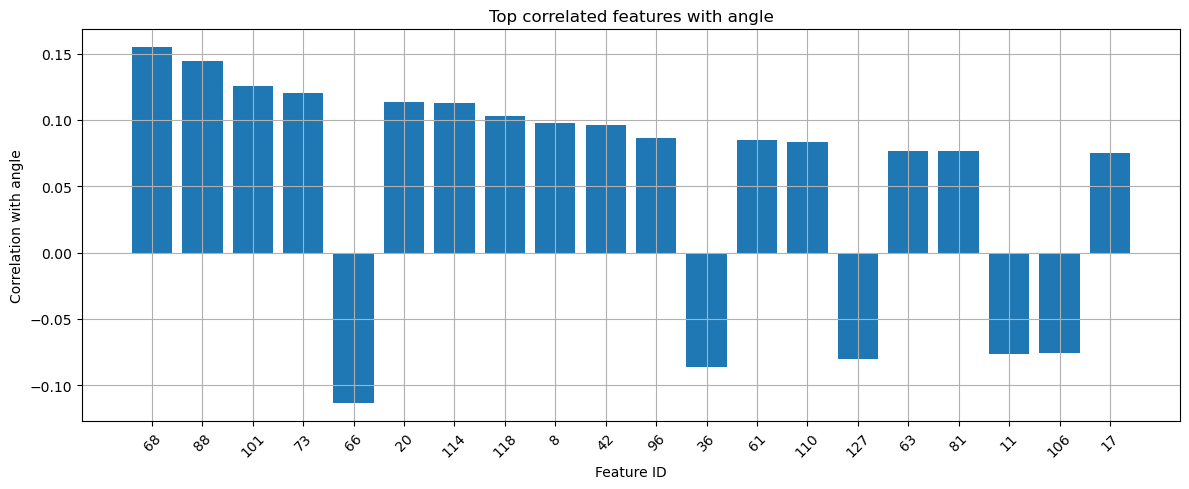

In [119]:
import torch
import numpy as np
from torch_geometric.nn import global_mean_pool


# Create a DataLoader for all data
all_loader = DataLoader(
    mol_dataset,
    batch_size=64,  # Use batch size of 1 for individual samples
    shuffle=False,
    follow_batch=['x_s', 'x_t']  # tells PyG to create x_s_batch, x_t_batch
)

pooled_features = []
angles_deg = []

with torch.no_grad():
    for pair in all_loader:
        x_s = gnn_s(pair.x_s, pair.edge_index_s, pair.edge_attr_s)
        x_t = gnn_t(pair.x_t, pair.edge_index_t, pair.edge_attr_t)

        batch_s = pair.x_s_batch
        batch_t = pair.x_t_batch

        pooled_s = global_mean_pool(x_s, batch_s)
        pooled_t = global_mean_pool(x_t, batch_t)

        pooled = torch.cat([pooled_s, pooled_t], dim=-1)  # shape: [B, 2*D]
        pooled_features.extend(pooled.cpu().numpy())

        # Get angles from y
        y_rad = np.arctan2(pair.y[:, 1], pair.y[:, 0])
        y_deg = np.degrees(y_rad) % 360
        angles_deg.extend(y_deg.tolist())
import matplotlib.pyplot as plt

X = np.vstack(pooled_features)
y = np.array(angles_deg)
print(f"X shape: {X.shape}, y shape: {y.shape}")

# Identify non-constant features
stds = X.std(axis=0)
non_constant_idx = np.where(stds > 1e-6)[0]  # threshold avoids near-constant features

correlations = []
feature_ids = []

for i in non_constant_idx:
    corr = np.corrcoef(X[:, i], y)[0, 1]
    correlations.append(corr)
    feature_ids.append(i)

# Convert to numpy for easy sorting
correlations = np.array(correlations)
feature_ids = np.array(feature_ids)

# Sort by absolute correlation
sorted_idx = np.argsort(-np.abs(correlations))
top_k = 20
top_corrs = correlations[sorted_idx[:top_k]]
top_feats = feature_ids[sorted_idx[:top_k]]

# Print top-k
for rank, (fid, corr) in enumerate(zip(top_feats, top_corrs), 1):
    print(f"Top {rank:2d}: Feature {fid:3d} | corr = {corr:+.3f}")

# Barplot
plt.figure(figsize=(12, 5))
plt.bar(range(top_k), top_corrs, tick_label=[str(f) for f in top_feats])
plt.xticks(rotation=45)
plt.xlabel("Feature ID")
plt.ylabel("Correlation with angle")
plt.title("Top correlated features with angle")
plt.tight_layout()
plt.grid(True)
plt.show()



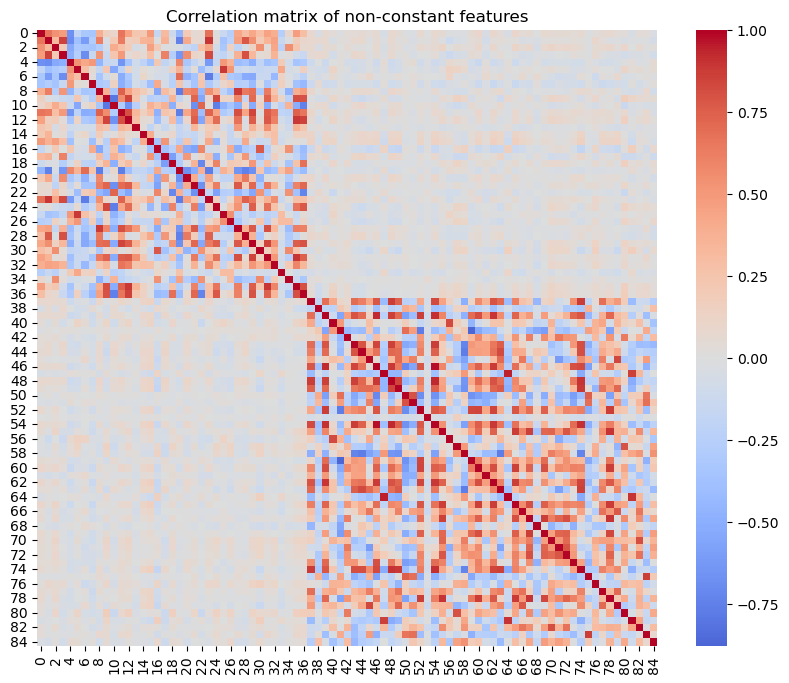

In [120]:
import seaborn as sns

corr_matrix = np.corrcoef(X[:, non_constant_idx].T)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title("Correlation matrix of non-constant features")
plt.show()


In [121]:
import numpy as np

# y: your array of angles in degrees
y_rad = np.deg2rad(y)        # convert degrees to radians
y_cos = np.cos(y_rad)        # cosine of angle
y_sin = np.sin(y_rad)        # sine of angle


In [122]:
print("Feature correlations with cos(θ) and sin(θ):\n")

for i in range(X.shape[1]):
    x_feat = X[:, i]
    
    if np.std(x_feat) < 1e-8:  # skip constant features
        continue

    corr_cos = np.corrcoef(x_feat, y_cos)[0, 1]
    corr_sin = np.corrcoef(x_feat, y_sin)[0, 1]
    
    print(f"Feature {i:3d}:  corr(cos) = {corr_cos:+.3f},  corr(sin) = {corr_sin:+.3f}")


Feature correlations with cos(θ) and sin(θ):

Feature   1:  corr(cos) = +0.014,  corr(sin) = -0.023
Feature   2:  corr(cos) = -0.023,  corr(sin) = -0.005
Feature   3:  corr(cos) = +0.073,  corr(sin) = -0.057
Feature   4:  corr(cos) = -0.022,  corr(sin) = +0.001
Feature   7:  corr(cos) = -0.052,  corr(sin) = -0.007
Feature   8:  corr(cos) = -0.038,  corr(sin) = -0.121
Feature   9:  corr(cos) = +0.001,  corr(sin) = -0.031
Feature  11:  corr(cos) = -0.035,  corr(sin) = +0.116
Feature  12:  corr(cos) = -0.046,  corr(sin) = -0.017
Feature  14:  corr(cos) = -0.037,  corr(sin) = -0.065
Feature  15:  corr(cos) = +0.059,  corr(sin) = +0.054
Feature  16:  corr(cos) = -0.004,  corr(sin) = -0.059
Feature  17:  corr(cos) = -0.013,  corr(sin) = -0.068
Feature  18:  corr(cos) = +0.005,  corr(sin) = -0.048
Feature  19:  corr(cos) = +0.010,  corr(sin) = -0.043
Feature  20:  corr(cos) = +0.028,  corr(sin) = -0.140
Feature  21:  corr(cos) = -0.018,  corr(sin) = +0.060
Feature  26:  corr(cos) = -0.019,  c

In [123]:
# Compute total magnitude of correlation
corr_mags = [
    (i, np.sqrt(np.corrcoef(X[:, i], y_cos)[0, 1]**2 + np.corrcoef(X[:, i], y_sin)[0, 1]**2))
    if np.std(X[:, i]) > 1e-8 else (i, 0.0)
    for i in range(X.shape[1])
]

# Sort by descending magnitude
top_corr = sorted(corr_mags, key=lambda x: -x[1])

# Print top 10
print("\nTop 10 features by vector correlation magnitude:")
for i, mag in top_corr[:10]:
    print(f"Feature {i:3d}: magnitude = {mag:+.3f}")



Top 10 features by vector correlation magnitude:
Feature  68: magnitude = +0.214
Feature  88: magnitude = +0.187
Feature 101: magnitude = +0.184
Feature 114: magnitude = +0.179
Feature 100: magnitude = +0.170
Feature 118: magnitude = +0.167
Feature  96: magnitude = +0.165
Feature  66: magnitude = +0.157
Feature  87: magnitude = +0.156
Feature  73: magnitude = +0.145


In [124]:
from sklearn.linear_model import LinearRegression
print(X.shape, y.shape)
# Combine y_sin and y_cos into a single 2D array
y = np.column_stack((y_sin, y_cos))  # shape [N, 2]
print(y.shape)

reg = LinearRegression().fit(X, y)  # X: [N, F], Y: [N, 2]


(1696, 128) (1696,)
(1696, 2)


In [125]:
print(len(pooled_features))  # Should match number of molecules/pairs


1696


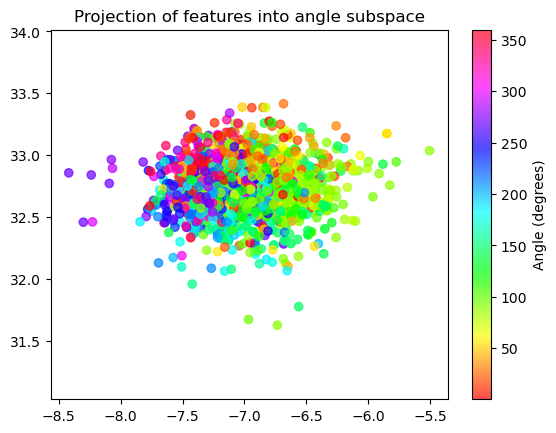

In [126]:
X_proj = X @ reg.coef_.T  # shape [N, 2]
import matplotlib.pyplot as plt
plt.scatter(X_proj[:, 0], X_proj[:, 1], c=angles_deg, cmap='hsv', alpha=0.7)
plt.colorbar(label='Angle (degrees)')
plt.axis('equal')
plt.title('Projection of features into angle subspace')
plt.show()


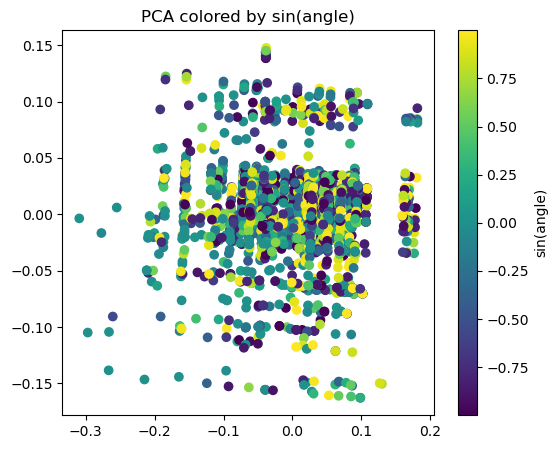

In [127]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assume X is your [N, F] feature matrix, y are angles in degrees

y_rad = np.arctan2(y[:, 1], y[:, 0])  # atan2(sin, cos)
y_cos = np.cos(y_rad)
y_sin = np.sin(y_rad)

# Run PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot colored by sin(angle)
plt.figure(figsize=(6, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_sin, cmap='viridis')
plt.colorbar(label='sin(angle)')
plt.title('PCA colored by sin(angle)')
plt.show()


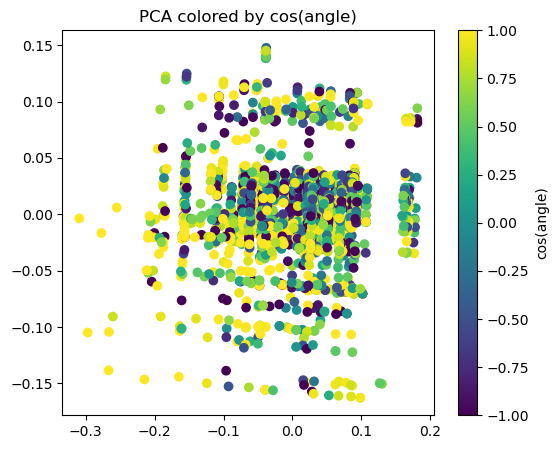

In [128]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assume X is your [N, F] feature matrix, y are angles in degrees

y_rad = np.arctan2(y[:, 1], y[:, 0])  # atan2(sin, cos)
y_cos = np.cos(y_rad)
y_sin = np.sin(y_rad)

# Run PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot colored by cos(angle)
plt.figure(figsize=(6, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_cos, cmap='viridis')
plt.colorbar(label='cos(angle)')
plt.title('PCA colored by cos(angle)')
plt.show()


In [129]:
loadings = pca.components_.T  # shape: [F, 2]
pc1_loadings = loadings[:, 0]
pc2_loadings = loadings[:, 1]

# Absolute value to get most influential features
top_pc1 = np.argsort(np.abs(pc1_loadings))[::-1][:10]
top_pc2 = np.argsort(np.abs(pc2_loadings))[::-1][:10]

print("Top features influencing PC1:", top_pc1)
print("Top features influencing PC2:", top_pc2)


Top features influencing PC1: [ 86 110  80  96  75  67  71  84  81  97]
Top features influencing PC2: [54 16  2 17 63 37 34 57 36 61]


In [130]:
top_feats

array([ 68,  88, 101,  73,  66,  20, 114, 118,   8,  42,  96,  36,  61,
       110, 127,  63,  81,  11, 106,  17])

In [131]:
len(X)

1696

In [132]:
top_feats

array([ 68,  88, 101,  73,  66,  20, 114, 118,   8,  42,  96,  36,  61,
       110, 127,  63,  81,  11, 106,  17])

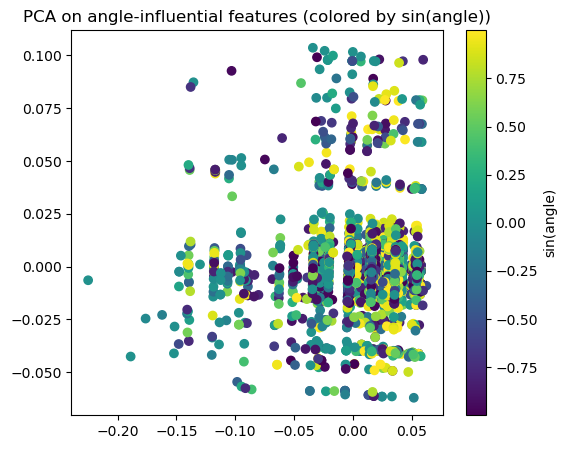

In [133]:
# Combine all unique top features from PC1 and PC2


X_angle = X[:, top_feats]
y_rad = np.arctan2(y[:, 1], y[:, 0])  # atan2(sin, cos)
y_cos = np.cos(y_rad)
y_sin = np.sin(y_rad)
pca_angle = PCA(n_components=2)
X_pca_angle = pca_angle.fit_transform(X_angle)

plt.figure(figsize=(6, 5))
plt.scatter(X_pca_angle[:, 0], X_pca_angle[:, 1], c=y_sin, cmap='viridis')
plt.colorbar(label='sin(angle)')
plt.title('PCA on angle-influential features (colored by sin(angle))')
plt.show()


In [134]:
print("Full PCA variance ratio:", pca.explained_variance_ratio_)
print("Pruned PCA variance ratio:", pca_angle.explained_variance_ratio_)


Full PCA variance ratio: [0.42121756 0.15855478]
Pruned PCA variance ratio: [0.5207944  0.17600194]


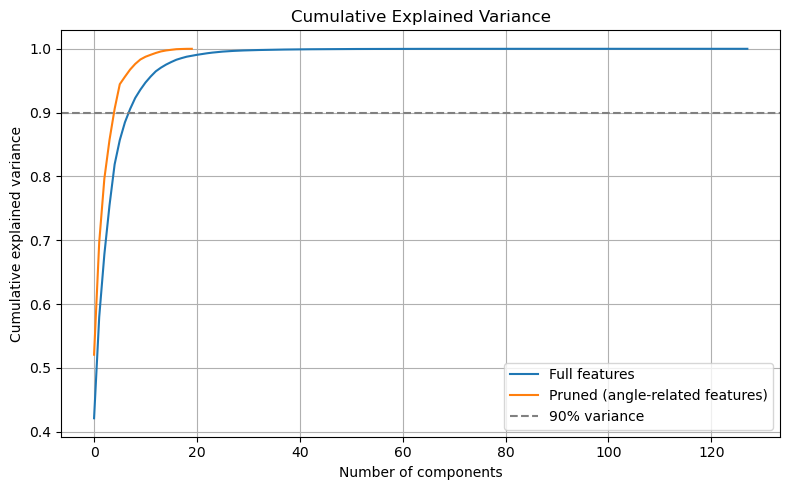

In [135]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Full PCA
pca_full = PCA()
X_pca_full = pca_full.fit_transform(X)
cumvar_full = np.cumsum(pca_full.explained_variance_ratio_)

# Pruned PCA (angle-influential features only)
X_angle = X[:, top_feats]  # `top_features` should be list/array of influential feature indices
pca_pruned = PCA()
X_pca_pruned = pca_pruned.fit_transform(X_angle)
cumvar_pruned = np.cumsum(pca_pruned.explained_variance_ratio_)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(cumvar_full, label='Full features')
plt.plot(cumvar_pruned, label='Pruned (angle-related features)')
plt.axhline(0.9, color='gray', linestyle='--', label='90% variance')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('Cumulative Explained Variance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


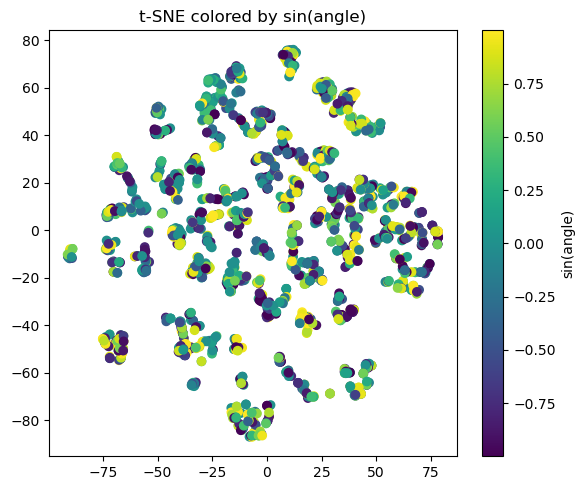

In [138]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Assume X is [N, F] and y is angle in degrees
y_rad = np.arctan2(y[:, 1], y[:, 0])  # atan2(sin, cos)
y_sin = np.sin(y_rad)
y_cos = np.cos(y_rad)

# Run t-SNE
tsne = TSNE(n_components=2, perplexity=10, learning_rate='auto', init='random', random_state=42)
X_tsne = tsne.fit_transform(X)

# Plot
plt.figure(figsize=(6, 5))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_sin, cmap='viridis')
plt.colorbar(label='sin(angle)')
plt.title("t-SNE colored by sin(angle)")
plt.tight_layout()
plt.show()


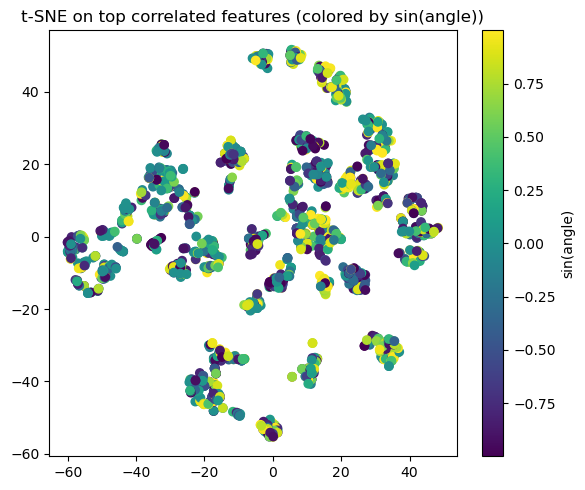

In [139]:
X_top = X[:, top_feats]  # use previously computed top_feats (e.g. top 20)
X_tsne_top = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='random', random_state=42).fit_transform(X_top)

plt.figure(figsize=(6, 5))
plt.scatter(X_tsne_top[:, 0], X_tsne_top[:, 1], c=y_sin, cmap='viridis')
plt.colorbar(label='sin(angle)')
plt.title("t-SNE on top correlated features (colored by sin(angle))")
plt.tight_layout()
plt.show()


In [149]:
!pip install umap-learn

/home/calvin/miniforge3/envs/dmpnn_rocm/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/calvin/miniforge3/envs/dmpnn_rocm/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


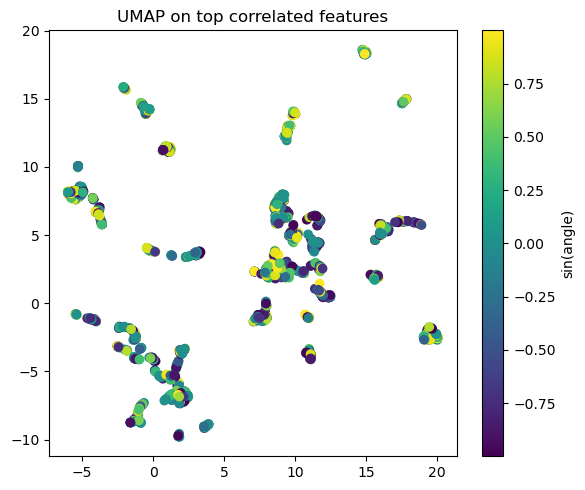

In [151]:
import umap.umap_ as umap
X_umap = umap.UMAP(n_components=2, random_state=42).fit_transform(X_top)

plt.figure(figsize=(6, 5))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y_sin, cmap='viridis')
plt.colorbar(label='sin(angle)')
plt.title("UMAP on top correlated features")
plt.tight_layout()
plt.show()


In [77]:
# y is your angle in degrees (shape [N])
# X is your [N, F] feature matrix

import numpy as np

# Convert angles to a scalar signal (e.g. sin or cos for linearization)
y_signal = y[:, 1]  # use sin(angle), or use y[:, 0] for cos(angle)
# Compute correlation per feature
feature_corrs = []
for i in range(X.shape[1]):
    xi = X[:, i]
    if np.isnan(xi).all():
        feature_corrs.append(np.nan)
    else:
        corr = np.corrcoef(xi, y_signal)[0, 1]
        feature_corrs.append(corr)

feature_corrs = np.array(feature_corrs)

/home/calvin/miniforge3/envs/dmpnn_rocm/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/calvin/miniforge3/envs/dmpnn_rocm/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [91]:
# Make sure feature_corrs exists and is clean
feature_corrs = np.array(feature_corrs)
valid_mask = ~np.isnan(feature_corrs)

# Filter for features with |correlation| > threshold
threshold = 0.10
strong_corr_mask = (np.abs(feature_corrs) > threshold) & valid_mask
strong_corr_idx = np.where(strong_corr_mask)[0]

print(f"{len(strong_corr_idx)} features passed the |corr| > {threshold} threshold.")


1 features passed the |corr| > 0.1 threshold.


In [92]:
N = 20  # or 30, 50...
sorted_idx = np.argsort(-np.abs(feature_corrs[valid_mask]))
top_feature_idx = np.where(valid_mask)[0][sorted_idx[:N]]
X_top = X[:, top_feature_idx]


In [93]:
X_top

array([[0.2857143 , 0.5714286 , 0.14285715, ..., 0.        , 0.        ,
        0.        ],
       [0.42857143, 0.5714286 , 0.2857143 , ..., 0.        , 0.        ,
        0.        ],
       [0.33333334, 0.6666667 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.33333334, 0.6666667 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.33333334, 0.6666667 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.33333334, 0.6666667 , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

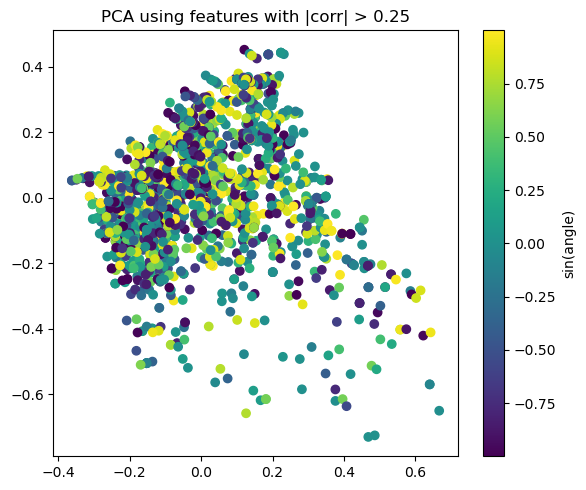

In [ ]:
# # Find feature indices with |correlation| > 0.25
# abs_corr = np.abs(feature_corrs)  # your array of shape (F,) with per-feature correlation
# strong_corr_idx = np.where(abs_corr > 0.25)[0]

# Subset X and run PCA
X_strong = X_top
pca_strong = PCA(n_components=2)
X_pca_strong = pca_strong.fit_transform(X_strong)

# Plot
plt.figure(figsize=(6, 5))
plt.scatter(X_pca_strong[:, 0], X_pca_strong[:, 1], c=y_sin, cmap='viridis')
plt.colorbar(label='sin(angle)')
plt.title('PCA using features with |corr| > 0.25')
plt.tight_layout()
plt.show()


In [71]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

# Targets
y_rad = np.arctan2(y[:, 1], y[:, 0])
y_cos = np.cos(y_rad)
y_sin = np.sin(y_rad)

# Regression on pruned features
reg_cos = Ridge().fit(X_angle, y_cos)
reg_sin = Ridge().fit(X_angle, y_sin)

# Predictions & performance
y_pred_cos = reg_cos.predict(X_angle)
y_pred_sin = reg_sin.predict(X_angle)

print("R² (cos component):", r2_score(y_cos, y_pred_cos))
print("R² (sin component):", r2_score(y_sin, y_pred_sin))


R² (cos component): 0.09330737590789795
R² (sin component): 0.024475812911987305


In [73]:
y

array([[ 0.994262  , -0.10697235],
       [ 0.9807075 , -0.19548094],
       [-0.99982345, -0.01878913],
       ...,
       [ 0.9874437 , -0.1579715 ],
       [ 0.81335557, -0.5817669 ],
       [ 0.7162982 , -0.69779426]], dtype=float32)

In [86]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y_sin, test_size=0.2, random_state=42)

reg = RandomForestRegressor()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print("R² (sin(angle)):", r2_score(y_test, y_pred))


R² (sin(angle)): -0.028918539445789815


In [89]:
nan_counts = np.isnan(X).sum(axis=0)
print("Features with most NaNs:", np.argsort(-nan_counts)[:])


Features with most NaNs: [255 254 253 252 251 250 249 248 247 246 245 244 243 242 241 240  15  14
  13  12  11  10   9   8   7   6   5   4   3   2   1 256  47  46  45  44
  43  42  41  40  39  38  37  36  35  34  33  32  63  62  61  60  59  58
  57  56  55  54  53  52  51  50  49  48  79  78  77  76  75  74  73  72
  71  70  69  68  67  66  65  64  95  94  93  92  91  90  89  88  87  86
  85  84  83  82  81  80 111 110 109 108 107 106 105 104 103 102 101 100
  99  98  97  96 127 126 125 124 123 122 121 120 119 118 117 116 115 114
 113 112 143 142 141 140 139 138 137 136 135 134 133 132 131 130 129 128
 159 158 157 156 155 154 153 152 151 150 149 148 147 146 145 144 175 174
 173 172 171 170 169 168 167 166 165 164 163 162 161 160 191 190 189 188
 187 186 185 184 183 182 181 180 179 178 177 176 207 206 205 204 203 202
 201 200 199 198 197 196 195 194 193 192 223 222 221 220 219 218 217 216
 215 214 213 212 211 210 209 208 239 238 237 236 235 234 233 232 231 230
 229 228 227 226 225 224  

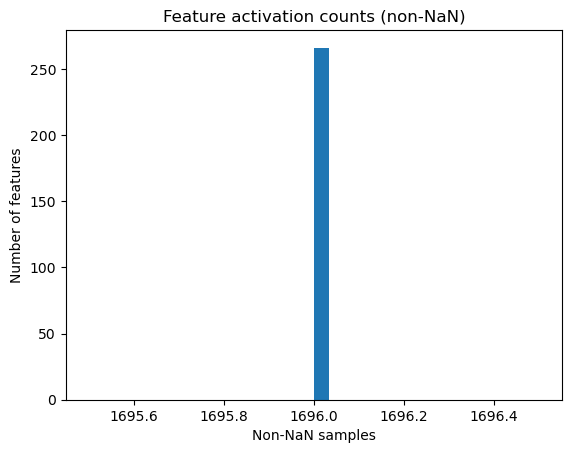

In [88]:
plt.figure()
plt.hist(X.shape[0] - nan_counts, bins=30)
plt.title("Feature activation counts (non-NaN)")
plt.xlabel("Non-NaN samples")
plt.ylabel("Number of features")
plt.show()
